In [1]:
import numpy as np
import tensorflow as tf
import mediapipe as mp
import numba
import cv2
import pandas as pd

print("NumPy:", np.__version__)
print("TensorFlow:", tf.__version__)
print("Mediapipe:", mp.__version__)
print("Numba:", numba.__version__)
print("OpenCV:", cv2.__version__)
print("Pandas:", pd.__version__)

NumPy: 1.26.4
TensorFlow: 2.15.0
Mediapipe: 0.10.11
Numba: 0.60.0
OpenCV: 4.9.0
Pandas: 2.2.1


In [11]:
import pandas as pd
import numpy as np
import cv2
import mediapipe as mp
from sklearn.model_selection import train_test_split

# Load FER2013
data = pd.read_csv('fer2013.csv')

# Convert pixel strings to images
def string_to_image(pixel_string):
    pixel_array = np.array(pixel_string.split(), dtype='float32')
    image = pixel_array.reshape(48, 48)
    return image

images = np.array([string_to_image(p) for p in data['pixels']])
labels = data['emotion'].values  # 0-6: Angry, Disgust, Fear, Happy, Sad, Surprise, Neutral

# Initial emotion-to-movement mapping
emotion_to_movement = {
    0: 4,  # Angry -> Smiley Stretch (approximation)
    1: 6,  # Disgust -> Lip Pucker
    2: 0,  # Fear -> Jaw Dropper
    3: 4,  # Happy -> Smiley Stretch
    4: 7,  # Sad -> Chin Jutter
    5: 1,  # Surprise -> Brow Lifter
    6: 8   # Neutral -> Forehead Smoother
}
new_labels = np.array([emotion_to_movement[label] for label in labels])

# Normalize images
images = images / 255.0
images = np.expand_dims(images, axis=-1)  # Shape: (num_samples, 48, 48, 1)

# Split dataset
train_images, test_images, train_labels, test_labels = train_test_split(
    images, new_labels, test_size=0.2, random_state=42
)
train_images, train_labels = train_images[:5000], train_labels[:5000]
test_images, test_labels = test_images[:1000], test_labels[:1000]

# Initialize Mediapipe
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)

# Heuristic functions with tuple-to-array conversion
def eye_aspect_ratio(landmarks, eye_indices):
    # Convert tuple landmarks to NumPy arrays
    p1, p2, p3, p4, p5, p6 = [np.array(landmarks[i]) for i in eye_indices]
    v1 = np.linalg.norm(p2 - p6)  # Vertical
    v2 = np.linalg.norm(p3 - p5)
    h = np.linalg.norm(p1 - p4)   # Horizontal
    return (v1 + v2) / (2.0 * h)

def mouth_aspect_ratio(landmarks, mouth_indices):
    # Convert tuple landmarks to NumPy arrays
    p1, p2, p3, p4 = [np.array(landmarks[i]) for i in mouth_indices]
    v = np.linalg.norm(p1 - p3)  # Vertical mouth opening
    h = np.linalg.norm(p2 - p4)  # Horizontal
    return v / h

def refine_labels(images, labels):
    refined_labels = labels.copy()
    for i, img in enumerate(images):
        img_rgb = cv2.cvtColor((img * 255).astype(np.uint8).reshape(48, 48), cv2.COLOR_GRAY2RGB)
        results = face_mesh.process(img_rgb)

        if results.multi_face_landmarks:
            landmarks = [(lm.x * 48, lm.y * 48) for lm in results.multi_face_landmarks[0].landmark]

            # Eye Winker (EAR < 0.2 for one eye)
            left_eye_indices = [33, 160, 158, 133, 153, 144]
            right_eye_indices = [362, 385, 387, 263, 373, 380]
            left_ear = eye_aspect_ratio(landmarks, left_eye_indices)
            right_ear = eye_aspect_ratio(landmarks, right_eye_indices)
            if left_ear < 0.2 or right_ear < 0.2:
                refined_labels[i] = 3  # Eye Winker

            # Jaw Dropper or Tongue Twister (mouth aspect ratio)
            mouth_indices = [13, 14, 78, 308]
            mar = mouth_aspect_ratio(landmarks, mouth_indices)
            if mar > 0.7:
                refined_labels[i] = 0  # Jaw Dropper
            elif mar > 0.5 and landmarks[13][1] > landmarks[14][1] + 5:
                refined_labels[i] = 9  # Tongue Twister

            # Cheek Puffer (cheek landmarks bulge outward)
            cheek_left = landmarks[205]
            cheek_right = landmarks[425]
            if abs(cheek_left[0] - cheek_right[0]) > 20:
                refined_labels[i] = 2  # Cheek Puffer

            # Nose Scruncher (nose tip moves up)
            nose_tip = landmarks[1]
            if nose_tip[1] < 20 and labels[i] == 1:  # Disgust with raised nose
                refined_labels[i] = 5  # Nose Scruncher

    return refined_labels

# Refine labels
train_labels = refine_labels(train_images, train_labels)
test_labels = refine_labels(test_images, test_labels)

print("Labels refined successfully!")

Labels refined successfully!


In [12]:
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def build_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')  # 10 movements
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Data augmentation
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)
datagen.fit(train_images)

# Train
model = build_model()
history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    epochs=50,
    validation_data=(test_images, test_labels),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
               tf.keras.callbacks.ModelCheckpoint('fer_movement_model.h5', save_best_only=True)]
)

# Evaluate
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/50
157/157 [==============================] - 31s 177ms/step - loss: 2.1628 - accuracy: 0.4054 - val_loss: 5.4293 - val_accuracy: 0.5890


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
157/157 [==============================] - 28s 175ms/step - loss: 1.3301 - accuracy: 0.5990 - val_loss: 2.4892 - val_accuracy: 0.5890
Epoch 3/50
157/157 [==============================] - 28s 177ms/step - loss: 1.1612 - accuracy: 0.6244 - val_loss: 1.6739 - val_accuracy: 0.6040
Epoch 4/50
157/157 [==============================] - 27s 173ms/step - loss: 1.0684 - accuracy: 0.6404 - val_loss: 1.0621 - val_accuracy: 0.6750
Epoch 5/50
157/157 [==============================] - 28s 176ms/step - loss: 1.0067 - accuracy: 0.6670 - val_loss: 1.1799 - val_accuracy: 0.6500
Epoch 6/50
157/157 [==============================] - 27s 175ms/step - loss: 1.0052 - accuracy: 0.6616 - val_loss: 0.9812 - val_accuracy: 0.6870
Epoch 7/50
157/157 [==============================] - 29s 184ms/step - loss: 0.9542 - accuracy: 0.6716 - val_loss: 0.9051 - val_accuracy: 0.7090
Epoch 8/50
157/157 [==============================] - 28s 176ms/step - loss: 0.9358 - accuracy: 0.6858 - val_loss: 1.1907 - val_ac

In [13]:
import cv2
import numpy as np
import tensorflow as tf
import mediapipe as mp

# Load model
model = tf.keras.models.load_model('fer_movement_model.h5')
movements = ["Jaw_Dropper", "Brow_Lifter", "Cheek_Puffer", "Eye_Winker", "Smiley_Stretch",
             "Nose_Scruncher", "Lip_Pucker", "Chin_Jutter", "Forehead_Smoother", "Tongue_Twister"]

# Mediapipe setup
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(max_num_faces=1)
mp_drawing = mp.solutions.drawing_utils

cap = cv2.VideoCapture(0)
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess for CNN
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (48, 48))
    input_img = resized / 255.0
    input_img = np.expand_dims(input_img, axis=[0, -1])

    # CNN prediction
    pred = model.predict(input_img)
    movement_idx = np.argmax(pred)
    movement = movements[movement_idx]

    # Refine with Mediapipe
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_frame)
    if results.multi_face_landmarks:
        landmarks = [(lm.x * frame.shape[1], lm.y * frame.shape[0]) for lm in results.multi_face_landmarks[0].landmark]

        # Apply heuristics
        left_ear = eye_aspect_ratio(landmarks, [33, 160, 158, 133, 153, 144])
        right_ear = eye_aspect_ratio(landmarks, [362, 385, 387, 263, 373, 380])
        if left_ear < 0.2 or right_ear < 0.2:
            movement = "Eye_Winker"

        mar = mouth_aspect_ratio(landmarks, [13, 14, 78, 308])
        if mar > 0.7:
            movement = "Jaw_Dropper"
        elif mar > 0.5 and landmarks[13][1] > landmarks[14][1] + 5:
            movement = "Tongue_Twister"

        cheek_left, cheek_right = landmarks[205], landmarks[425]
        if abs(cheek_left[0] - cheek_right[0]) > frame.shape[1] * 0.1:
            movement = "Cheek_Puffer"

        # Draw landmarks (optional)
        mp_drawing.draw_landmarks(frame, results.multi_face_landmarks[0], mp_face_mesh.FACEMESH_TESSELATION)

    # Display
    cv2.putText(frame, movement, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow("Facial Movement Detection", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

32/32 [==============================] - 1s 30ms/step - loss: 0.7385 - accuracy: 0.7590
Test Accuracy: 0.7590, Test Loss: 0.7385


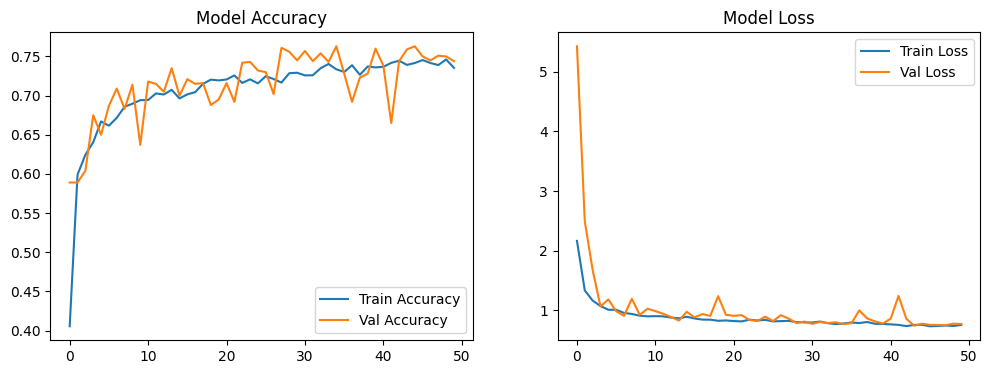

In [14]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

In [ ]:
cap = cv2.VideoCapture(0)  # Open webcam
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert to grayscale and preprocess
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (48, 48))
    input_img = resized / 255.0
    input_img = np.expand_dims(input_img, axis=[0, -1])  # Shape: (1, 48, 48, 1)

    # Predict
    prediction = model.predict(input_img)
    emotion_idx = np.argmax(prediction)
    label = emotions[emotion_idx]

    # Display result
    cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow('Facial Expression Detection', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()